In [30]:
import numpy as np
import math
import scipy.stats as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import time
import ipywidgets as wg

#import graphviz
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import IPython
from IPython.display import HTML, display, clear_output

import pickle

from decimal import Decimal
#from astropy import stats
from joblib import Parallel, delayed

# General function definitions 

In [31]:
def specific_heat(x):
    ''' Calculates specific heat.
        
        Parameters: 
            x: dtype numpy array
                One dimensional array containing the energy data (or equivalent quantity)
            
        Returns: dtype numpy array
            One dimensional array containing the specific heat data'''
    
    cv = (np.var(x, axis=0))/(T**2)
    return(cv)

In [32]:
def susceptiblity(mag):
    ''' Calculates specific heat.
        
        Parameters: 
            mag: dtype numpy array
                One dimensional array containing the magnetization data
            
        Returns: dtype numpy array
            One dimensional array containing the susceptibility data'''
    
    susc = (np.var(mag))/T
    return(susc)

# Network function definitions

In [33]:
def network_energy_calc(N_edges, n_l):
    # n_l is the total number of possible cross-edges (possible nn interactions)
    nwEl = (2*N_edges)-n_l
    return(nwEl)

In [34]:
def number_of_RGsteps(n):
    
    tel = 0
    neG_baseline = n-1
    lat_size = n 
    while n > 1:
        if n%2 != 0:
            raise ValueError("%d is not a power of the blocking size 2"%(lat_size))
        tel += 1
        n = n/2
        neG_baseline += n
    return(tel, neG_baseline)

In [35]:
def RGlats_skeleton():
    """ Creates the 'bare' shells of the RGb graph. That is, a list of spin lattices of decreasing size in accordance with the 
        branching factor 2, that serve as 'skeleton lattices' that can be modified by the RGb procedure
        
        Returns: 
            lats: dtype list
                list of lattice arrays. They serve as the initial spin lattices that constitute the shells of the RGb graph
    """
    lats = []; lats.append(np.zeros(N))
    n_nodes_shell = N
    while n_nodes_shell > 1:
        n_nodes_shell //= 2
        new_lat = np.zeros(n_nodes_shell)
        lats.append(new_lat)
    return(lats)
        

In [36]:
print(number_of_RGsteps(16))
N = 8
ls = RGlats_skeleton()
RGnegs = ls[:-1]
print(ls)
print(RGnegs)


(4, 30.0)
[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0.]), array([0.])]
[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0.])]


In [37]:
def RGgraph_skeleton():
    """ Creates boundary graph (collection of nodes) corresponding to the spin lattice, and the 'bare' tree graph
        
        Returns:
            bdG: dtype networkx multigraph
                boundary graph
            
            bulkG: dtype networkx multigraph
                'bare' tree graph, i.e. the boundary + bulk tree graph that serves as a skeleton for the RGb graph
    """
    # Boundary graph
    bdG = nx.MultiGraph()
    for i in range(N):
        bdG.add_node(i)
    # Bulk graph
    n_nodes_shell = N; add = 0
    bulkG = bdG.copy()
    while n_nodes_shell > 1:
        for k in np.arange(0,n_nodes_shell,2):
            n_Gr = nx.number_of_nodes(bulkG); bulkG.add_node(n_Gr)
            bulkG.add_edge(n_Gr,k+add); bulkG.add_edge(n_Gr,k+1+add)
        add += n_nodes_shell
        n_nodes_shell //= 2
    return(bdG, bulkG)
        
    

In [38]:
def create_frozen_map(lat):
    """ Creates a boolean map of (freezes) all bonds (nn interactions) in the lattice
    
        Input:
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
        Returns:
            f_map: dtype numpy array
                [N] boolean array containing True if bond is present or False if not. For example spin lattice [1, -1, 1, 1]
                corresponds to f_map [True, True, False, False]
    """
    lat = np.array(lat)
    a = lat[1:]-lat[0:len(lat)-1]; b = lat[0]-lat[len(lat)-1]
    c = np.append(a,b)
    f_map = (c == 0)
    return(f_map)

In [39]:
def construct_graph(lat, lats, Gr):
    """ Construct graph from spin lattice according to the RGb procedure
        
        Input: 
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
            lats: dtype list
                list containing the initial spin lattices that constitutes the shells of the graph (i.e. as constructed by the 
                function 'RGlats_skeleton')
            
            Gr: dtype networkx multigraph
                'bare' tree graph that serves as the 'skeleton' for the RGb graph (i.e. as constructed by the function 
                'RGgraph_skeleton')
            
        Returns: 
            Gr: dtype networkx multigraph
                RGb graph
    """
    n_nodes_shell = N; shell = 0
    add = 0 
    Gr = Gr.copy()
    while shell < len(lats):
        lats[shell] = lat
        if shell == (len(lats)-1):
            break
            
        # Update RG graph accordingly:
        frm = create_frozen_map(lat)
        idx = np.where(frm==False)
        for i in idx[0]:
            Gr.add_edge(i+add, (i+1)%n_nodes_shell+add)    
        add += n_nodes_shell
        
        # Do RG step:
        old_lat = lat
        n_nodes_shell //= 2
        lat = lat.reshape(n_nodes_shell, 2)
        lat = np.sum(lat, axis=1)
        # Deal with ties:
        idx_zeros = np.where(lat==0)
        old_idx_zeros = tuple([2*i for i in idx_zeros])
        lat[idx_zeros] = old_lat[old_idx_zeros] #np.random.choice([1,-1], size=len(idx_zeros[0]))
        lat = lat/abs(lat)
        
        shell += 1
    return(Gr)

In [40]:
def construct_graph_eff(lat, n_shells):
    n_nodes_shell = N; shell = 0
    neGr = np.zeros(n_shells)
    NWen = np.zeros(n_shells)
    
    while shell < n_shells:
        # Update RG graph accordingly:
        fr = create_frozen_map(lat)
        idx = np.where(fr==False)
        N_edges = len(idx[0])
        neGr[shell] = N_edges
        # Calculate network energy
        NWen[shell] = network_energy_calc(N_edges, n_nodes_shell)
        # Do RG step:
        old_lat = lat
        n_nodes_shell //= 2
        lat = lat.reshape(n_nodes_shell, 2)
        lat = np.sum(lat, axis=1)
        idx_zeros = np.where(lat==0)
        old_idx_zeros = tuple([2*i for i in idx_zeros])
        lat[idx_zeros] = old_lat[old_idx_zeros] #np.random.choice([1,-1], size=len(idx_zeros[0]))
        lat = lat/abs(lat)
        
        shell += 1
    return(neGr, NWen)

# Metropolis function definitions

In [41]:
def metropolis(lat,lats,G,bulkG,neGbase,Enw,M,Tl,geom):
    ''' Implement metropolis algorithm for a single spin flip with probability given by the number of cross-edges of network 
        that corresponds to the lattice
    
        Parameters: 
            lat: dtype numpy array
                [N] array representing the lattice
            Enw: dtype float or int
                Energy will be given by the number of cross-edges of the network corresponding to the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    # Select random spin (propose trial lattice with probability 1/L):
    x = np.random.randint(0,N)
    trial_lat = np.copy(lat)
    trial_lat[x] *= -1
    # Construct corresponding network:
    trialG = construct_graph(trial_lat, lats, bulkG.copy())
    # Calculate energy difference between the old and trial configurations:
    trialEnw = geom*network_energy_calc(nx.number_of_edges(trialG)-neGbase,neGbase)
    dEnw = trialEnw - Enw
    # Implement second stage of the metropolis algorithm:
    if dEnw <= 0:
        Enw = Enw + dEnw
        M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
        lat[x] = trial_lat[x]
        G = trialG
    else:
        r = np.random.uniform(0,1)
        p=np.exp(-dEnw/Tl)#p = exp[0]
        if r < p:
            Enw = Enw + dEnw
            M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
            lat[x] = trial_lat[x]
            G = trialG
    return(lat,G,Enw,M)

In [42]:
def metropolis_eff(lat,nRGsteps,Nedges,NWenergy,Enw,M,Tl,geom):
    ''' Implement metropolis algorithm for a single spin flip with probability given by the number of cross-edges of network 
        that corresponds to the lattice
    
        Parameters: 
            lat: dtype numpy array
                [N] array representing the lattice
            Enw: dtype float or int
                Energy will be given by the number of cross-edges of the network corresponding to the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    # Select random spin (propose trial lattice with probability 1/L):
    x = np.random.randint(0,N)
    trial_lat = np.copy(lat)
    trial_lat[x] *= -1
    # Construct corresponding network:
    trialNedges, trialNWenergy = construct_graph_eff(trial_lat, nRGsteps)
    # Calculate energy difference between the old and trial configurations:
    trialEnw = geom*np.sum(trialNWenergy)
    dEnw = trialEnw - Enw
    # Implement second stage of the metropolis algorithm:
    if dEnw <= 0:
        Enw = Enw + dEnw
        M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
        lat[x] = trial_lat[x]
        Nedges = trialNedges; NWenergy = trialNWenergy
    else:
        r = np.random.uniform(0,1)
        p=np.exp(-dEnw/Tl)#p = exp[0]
        if r < p:
            Enw = Enw + dEnw
            M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
            lat[x] = trial_lat[x]
            Nedges = trialNedges; NWenergy = trialNWenergy
    return(lat,Nedges,NWenergy,Enw,M)

# Exhibition

In [43]:
def exhibition(temp, save):
    t_sim = 20
    #global T
    #T = temp
    #global exp
    #exp = np.array([np.exp(-4/T),1,np.exp(4/T)]) # Store possible values of the acceptance probability (only need first value for metropolis)
    #global A_wolff
    #A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
    # Check if N is a power of the block size
    nRGsteps, neGbase = number_of_RGsteps(N)
    
    # Initialize lattice
    lattice = -1*np.ones(N) 
    #lattice = np.random.choice([1,-1],size=(N))
    
    # Geometric factor
    geom = 1/2

    # Initialize figure
    %matplotlib notebook
    fig = plt.figure(figsize=(10,5)); plt.axis('off'); plt.title('N=%d, T=%.1f'%(N,temp))
    ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
    ax1.set_axis_off()
    
    # Initialize RG lattices
    lattices = RGlats_skeleton()

    # Initialize boundary and bulk graph
    bdG, bulkG = RGgraph_skeleton()
    
    # Construct graph:
    graph = construct_graph(lattice, lattices, bulkG)
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    Enw = geom*network_energy_calc(nx.number_of_edges(graph)-neGbase,neGbase); M = np.sum(lattice) 

    for j in range(t_sim):
        # Perform one MCS using metropolis algorithm:
        for k in range(N):
            lattice, graph, Enw, M = metropolis(lattice,lattices,graph,bulkG,neGbase,Enw,M,temp,geom)
            
        # Perform cluster flip using wolff algorithm:
        #lattice, E, M = Wolff(lattice,E,M)     
        
        # Draw boundary graph
        nx.draw_networkx(bdG,pos=nx.circular_layout(bdG),with_labels=True,node_color=lattice,ax=ax1,font_size=10)#,cmap=plt.cm.GnBu,vmin=-2,vmax=2)
        
        # Draw bulk graph
        ax2.clear(); ax2.set_axis_off()
        #graph = construct_graph(lattice, lattices, bulkG.copy())
        pos=graphviz_layout(graph,prog='twopi', root='%d'%(neGbase))
        nx.draw_networkx(graph,pos=pos,with_labels=True,ax=ax2,node_size=20,font_size=8, node_color='r')
    
        fig.canvas.draw()
        #time.sleep(1)
        
    if save:
        plt.savefig('nwpRG1DcorrespondenceN=%dT=%d'%(N,temp))
    #nx.write_gml(graph,'howtree.gml')

In [45]:
N = 8
wg.interact_manual(exhibition, temp=(0.1,100), save=False)

interactive(children=(FloatSlider(value=50.050000000000004, description='temp', min=0.1), Checkbox(value=False…

<function __main__.exhibition(temp, save)>

# Results 

In [46]:
def simulate(lat, Tl, geom):
    # Check if N is a power of the block size
    nRGsteps, neGbase = number_of_RGsteps(N)
    
    # Initialise:
    configs = np.zeros([t_sim,N]) # [t_sim,N] array to store the configurations of the lattice 
    en_nw = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy E and magnetisation M 
    graphs = [] # list to store (bulk)graphs corresponding to the lattice during simulation
    
    # Initialize RG lattices
    lats = RGlats_skeleton()
    
    # Initialize boundary and bulk graph
    bdG, bulkG = RGgraph_skeleton()
    graph = construct_graph(lat, lats, bulkG.copy())
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    Enw = geom*network_energy_calc(nx.number_of_edges(graph)-neGbase,neGbase); M = np.sum(lat)
    
    t1 = time.time()    
    # Simulation:
    for j in range(t_sim):
        # Store data:
        configs[j] = lat; en_nw[j] = Enw; mag[j] = M
        graphs.append(graph)
        
        # Perform one MCS using metropolis algorithm:
        for k in range(N):
            lat, graph, Enw, M = metropolis(lat,lats,graph,bulkG,neGbase,Enw,M,Tl,geom)
            
        # Perform cluster flip using wolff algorithm:
        #lat, E, M = Wolff(lat,E,M) 
            
        # Create bulk graph
        #graph = construct_graph(lat, lats, bulkG.copy())
        
        t2 = time.time()
        
        if j%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(j/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if j == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en_nw, mag, graphs)

In [47]:
def simulate_eff(lat, Tl, geom):
    # Check if N is a power of the block size
    nRGsteps, neGbase = number_of_RGsteps(N)
    
    # Initialise:
    configs = np.zeros([t_sim,N]) # [t_sim,N] array to store the configurations of the lattice 
    en_nw = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy E and magnetisation M 
    neg = np.zeros([t_sim,nRGsteps]); nwe = np.zeros([t_sim,nRGsteps])
                   
    # Calculate number of edges
    N_edges, NWenergy = construct_graph_eff(lat, nRGsteps)
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    Enw = geom*np.sum(NWenergy); M = np.sum(lat)
    
    t1 = time.time()    
    # Simulation:
    for j in range(t_sim):
        # Store data:
        configs[j] = lat; en_nw[j] = Enw; mag[j] = M
        neg[j] = N_edges; nwe[j] = NWenergy
        
        # Perform one MCS using metropolis algorithm:
        for k in range(N):
            lat, N_edges, NWenergy, Enw, M = metropolis_eff(lat,nRGsteps,N_edges,NWenergy,Enw,M,Tl, geom)
            
        # Perform cluster flip using wolff algorithm:
        #lat, E, M = Wolff(lat,E,M) 
            
        # Create bulk graph
        #N_edges, NWenergy = construct_graph_eff(lat, nRGsteps)
        
        t2 = time.time()
        
        if j%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(j/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if j == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en_nw, mag, neg, nwe)

### Equilibrium

Set temperatures:

In [48]:
temperatures = np.geomspace(0.1, 8, 34)
print(temperatures)

new = False
if new:
    possibleScales = []
    LinitC = []; Len_nw_data = []
    Lmag_data= []; t_sim = 0
    
    nwpEqData = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Lmag_data': Lmag_data, 
                 'Len_nw_data': Len_nw_data, 'LinitC': LinitC}
    
    pickle.dump(nwpEqData, open('nwp1DeqData.p', 'wb'))

[0.1        0.11420087 0.13041838 0.14893891 0.17008953 0.19424371
 0.221828   0.25332949 0.28930447 0.33038821 0.37730619 0.43088694
 0.49207661 0.56195575 0.64175832 0.73289356 0.83697078 0.95582787
 1.0915637  1.24657519 1.42359964 1.62576311 1.85663553 2.12029384
 2.42139391 2.76525279 3.1579426  3.60639777 4.11853745 4.70340539
 5.37132964 6.13410492 7.00520088 8.        ]


In [51]:
run = False
# Set system parameters (note that these are global!):
N = 64 # Lattice number
#temperatures = np.geomspace(0.1, 6, 5) # Temperature (critical at around 2.27)
t_eq = 1000
t_prod = 0
t_sim = t_eq + t_prod

geom =1/2

mag_data = []
en_nw_data = []
initC = []

lattice = np.ones(N)

if run:
    for T in temperatures:
        #lattice = np.random.choice([1,-1],size=(N,N)) # Initial lattice configuration
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, Enw, M, _, _ = simulate_eff(lattice, T, geom)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
        initC.append(np.copy(C[-1]))
        
        mag_data.append(abs(M))
        en_nw_data.append(Enw)

In [52]:
nwpEqData = pickle.load(open('nwp1DeqData.p', 'rb'))
possibleScales = nwpEqData['possibleScales']; temperatures = nwpEqData['temperatures']
Len_nw_data = nwpEqData['Len_nw_data']; Lmag_data = nwpEqData['Lmag_data']
LinitC = nwpEqData['LinitC']


save = False
if save:
    possibleScales.append(N)
    Len_nw_data.append(en_nw_data); Lmag_data.append(mag_data)
    LinitC.append(initC); 
    
    nwpEqData = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Len_nw_data': Len_nw_data, 
                   'Lmag_data': Lmag_data, 'LinitC': LinitC}
    pickle.dump(nwpEqData, open('nwp1DeqData.p', 'wb'))

In [53]:
idx = 0
print(Lmag_data[idx][13][-1])
print(np.sum(LinitC[idx][13]))

60.0
60.0


In [54]:
idx = 0
L = possibleScales[idx]
print(LinitC[idx][0])
print(np.where(LinitC[idx][0]!=np.ones(L)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(array([], dtype=int64),)


possibleScales:  [64]


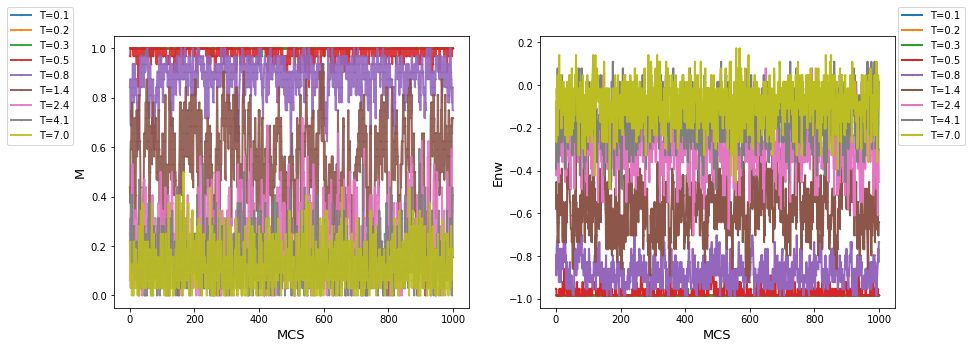

In [55]:
%matplotlib inline
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
save = False
idx = 0


if not save:
    nwpEqData = pickle.load(open('nwp1DeqData.p', 'rb'))
    t_sim = nwpEqData['t_sim']; possibleScales = nwpEqData['possibleScales']; Lmag_data = nwpEqData['Lmag_data']
    Len_nw_data = nwpEqData['Len_nw_data']; temperatures = nwpEqData['temperatures']
    
print('possibleScales: ', possibleScales)
    
t = np.arange(t_sim)
step = 4
L = possibleScales[idx]

for i, item in enumerate(temperatures[::step]):
    ax1.plot(t,Lmag_data[idx][i*step]/L, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1, alpha=0.9)
    ax2.plot(t,Len_nw_data[idx][i*step]/L, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1)
    
ax1.set_xlabel('MCS',fontsize=13); ax1.set_ylabel('M', fontsize=13)
ax2.set_xlabel('MCS',fontsize=13); ax2.set_ylabel('Enw', fontsize=13)
ax1.legend(loc=(-0.3,0.6)); ax2.legend(loc=(1.01,0.6))


if save:
    plt.savefig('nwp1Dequitime')
    nwpEqData = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Len_nw_data': Len_nw_data, 
                   'Lmag_data': Lmag_data, 'LinitC': LinitC}
    pickle.dump(nwpEqData, open('nwp1DeqData.p', 'wb'))

### Correlation function

In [56]:
def corr_func_calc(x):
    ''' Calculated the correlation function of a data set (Magnetization/energy/specific heat/susceptibility)

        Parameters: 
            x: dtype numpy array or list
                One dimensional list or array containing the data
        
        Returns: dtype numpy array
            The correlation function'''
    
    t_max = len(x)
    c = np.zeros(t_max)
    for i in range(t_max):
        denom = t_max-i
        c[i] = (np.sum(x[:t_max-i]*x[i:t_max])/denom)-(np.sum(x[:t_max-i])*np.sum(x[i:t_max])/(denom**2))
    c = c/c[0]
    return(c)

In [57]:
def corr_time(corr, acc):
    ''' Automatically fits the correlation function to an exponention function and finds the decay length
        
        Parameters:
            corr: dtype numpy array
                The correlation function of a data set
            
        Returns: dtype float
            The decay length of the exponential fit'''
    
    l =0; k = np.argmax(corr<0)-1
    corr_decay = np.log(corr[l:k])
    t = np.arange(t_prod)
    #print(len(t[l:k]),len(corr_decay))
    slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay)

    while r_val**2<acc:
        k -= 1
        slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay[:k])
    
    #return (slope, cep, r_val, err, t[l:k], corr_decay[:k])
    #plt.plot(t[l:k],corr_decay[:k])
    #plt.plot(t[l:k],cep+slope*t[l:k])
    #plt.show()
    tau = -1/slope
    return(tau)

In [58]:
def corr_and_error(x):
    corr = corr_func_calc(x)
    if (corr[0]==np.nan) or (np.argmax(corr<0)<3):
        tau = 0
        sigma = np.std(x)
    else: 
        tau = corr_time(corr, 0.98)
        sigma = np.sqrt(2*(tau/len(x))*np.std(x))                    
    return(corr, tau, sigma)
       

In [59]:
def plot_corr_shells(Lcorr_neg_data, Lcorr_nwe_data, Lidx, Tidx, step):
    L = possibleScales[Lidx]; nRGsteps, neg_baseline = number_of_RGsteps(L)
    temp = temperatures[Tidx]
    
    fig = plt.figure(figsize=(14,5)); plt.axis('off'); plt.title('L=%d, T=%.2f'%(N,temp))
    ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
    t = np.arange(len(Lcorr_neg_data[0][0][0]))
    
    for l in range(nRGsteps)[::step]:
        ax1.plot(t,Lcorr_neg_data[Lidx][Tidx][l], linewidth=2, label=('shell={}'.format(l)), alpha=0.9)
        ax2.plot(t, Lcorr_nwe_data[Lidx][Tidx][l], label=('shell={}'.format(l)))
    
    ax1.set_xlabel('MCS',fontsize=13); ax1.set_ylabel('Corr_neg', fontsize=13)
    ax2.set_xlabel('MCS',fontsize=13); ax2.set_ylabel('Corr_nwe', fontsize=13)
    ax1.legend(loc=(-0.3,0.63)); ax2.legend(loc=(1.01,0.63))


In [60]:
#temperatures = np.geomspace(0.1, 8, 34)
print(temperatures)

new = False
if new:
    possibleScales = []
    LcorrEnw_data = []; LtauEnw_data = []
    LcorrMdata = []; LtauMdata = []
    Lcorr_neg_data = []; Ltau_neg_data = []
    Lcorr_nwe_data = []; Ltau_nwe_data = []
    
    nwpCorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEnw_data': LcorrEnw_data, 
                   'LtauEnw_data': LtauEnw_data, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 
                   'Lcorr_neg_data': Lcorr_neg_data, 'Ltau_neg_data': Ltau_neg_data, 'Lcorr_nwe_data': Lcorr_nwe_data,
                   'Ltau_nwe_data': Ltau_nwe_data}
    pickle.dump(nwpCorrData, open('nwp1DcorrData.p', 'wb'))

[0.1        0.11420087 0.13041838 0.14893891 0.17008953 0.19424371
 0.221828   0.25332949 0.28930447 0.33038821 0.37730619 0.43088694
 0.49207661 0.56195575 0.64175832 0.73289356 0.83697078 0.95582787
 1.0915637  1.24657519 1.42359964 1.62576311 1.85663553 2.12029384
 2.42139391 2.76525279 3.1579426  3.60639777 4.11853745 4.70340539
 5.37132964 6.13410492 7.00520088 8.        ]


In [61]:
run = False

if run:
    #run = False
    # Set system parameters (note that these are global!):
    N = 1024
    t_eq = 1000
    t_prod = 500
    t_sim = t_eq + t_prod
    
    nRGsteps, neg_baseline = number_of_RGsteps(N)
    
    corrEnw_data = []; tauEnw_data = np.zeros(len(temperatures)) 
    corrMdata = []; tauMdata = np.zeros(len(temperatures)) 
    corr_neg_data = []; tau_neg_data = np.zeros((len(temperatures),nRGsteps))
    corr_nwe_data = []; tau_nwe_data = np.zeros((len(temperatures),nRGsteps))
    
    # Initial lattice configuration  
    lattice = -1*np.ones(N)  
    #lattice = np.random.choice([1,-1],size=(N))
    
    for j,T in enumerate(temperatures):
        #if 0.18<T and T<0.8:
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, Enw, M, neg, nwe = simulate_eff(lattice, T)
        clear_output(wait=True)
        
        lattice = np.copy(C[-1])
                        
        corrEnw, tauEnw, sigmaEnw = corr_and_error(Enw[t_eq:])
        corrM, tauM, sigmaM = corr_and_error(abs(M[t_eq:]))
            
        #if tauM > 41:
            #print('fail')
            #print(T)
            #print(tauM)
            #run = True
            #break
        '''else:
            corrEnw = np.zeros(t_prod); tauEnw = np.nan; sigmaEnw = np.nan
            corrEnw[:] = np.nan
            corrM = np.zeros(t_prod); tauM = np.nan; sigmaM = np.nan
            corrM[:] = np.nan
        '''
        
        corrEnw_data.append(corrEnw); tauEnw_data[j] = tauEnw
        corrMdata.append(corrM); tauMdata[j] = tauM  
        
        corr_neg = []; tau_neg = np.zeros(nRGsteps)
        corr_nwe = []; tau_nwe = np.zeros(nRGsteps)
        for l in range(nRGsteps):
            corr_neg_l, tau_neg_l, sigma_neg_l = corr_and_error(neg[t_eq:,l])
            corr_nwe_l, tau_nwe_l, sigma_nwe_l = corr_and_error(nwe[t_eq:,l])
            corr_neg.append(corr_neg_l); tau_neg[l] = tau_neg_l
            corr_nwe.append(corr_nwe_l); tau_nwe[l] = tau_nwe_l
            
        corr_neg_data.append(corr_neg); tau_neg_data[j] = tau_neg
        corr_nwe_data.append(corr_nwe); tau_nwe_data[j] = tau_nwe

tauEnw_data

idx = 0

LcorrEnw_data[idx] = corrEnw_data; LtauEnw_data[idx] = tauEnw_data
Lcorr_neg_data[idx] = corr_neg_data; Ltau_neg_data[idx] = tau_neg_data
Lcorr_nwe_data[idx] = corr_nwe_data; Ltau_nwe_data[idx] = tau_nwe_data

LcorrMdata[idx] = corrMdata; LtauMdata[idx] = tauMdata 

nwpCorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEnw_data': LcorrEnw_data, 
               'LtauEnw_data': LtauEnw_data, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 
               'Lcorr_neg_data': Lcorr_neg_data, 'Ltau_neg_data': Ltau_neg_data, 'Lcorr_nwe_data': Lcorr_nwe_data, 
               'Ltau_nwe_data': Ltau_nwe_data}
pickle.dump(nwpCorrData, open('nwp1DcorrData.p', 'wb'))

In [63]:
nwpCorrData = pickle.load(open('nwp1DcorrData.p', 'rb'))
possibleScales = nwpCorrData['possibleScales']; temperatures = nwpCorrData['temperatures']
LcorrEnw_data = nwpCorrData['LcorrEnw_data']; LtauEnw_data = nwpCorrData['LtauEnw_data']
LcorrMdata = nwpCorrData['LcorrMdata']; LtauMdata = nwpCorrData['LtauMdata']
Lcorr_neg_data = nwpCorrData['Lcorr_neg_data']; Ltau_neg_data = nwpCorrData['Ltau_neg_data']
Lcorr_nwe_data = nwpCorrData['Lcorr_nwe_data']; Ltau_nwe_data = nwpCorrData['Ltau_nwe_data']

save = False
if save:
    possibleScales.append(N)
    LcorrEnw_data.append(corrEnw_data); LtauEnw_data.append(tauEnw_data)
    LcorrMdata.append(corrMdata); LtauMdata.append(tauMdata)
    Lcorr_neg_data.append(corr_neg_data); Ltau_neg_data.append(tau_neg_data)
    Lcorr_nwe_data.append(corr_nwe_data); Ltau_nwe_data.append(tau_nwe_data)
    
    nwpCorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEnw_data': LcorrEnw_data, 
                   'LtauEnw_data': LtauEnw_data, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 
                   'Lcorr_neg_data': Lcorr_neg_data, 'Ltau_neg_data': Ltau_neg_data, 'Lcorr_nwe_data': Lcorr_nwe_data, 
                   'Ltau_nwe_data': Ltau_nwe_data}
    pickle.dump(nwpCorrData, open('nwp1DcorrData.p', 'wb'))

In [64]:
save = False

if not save:
    nwpCorrData = pickle.load(open('nwp1DcorrData.p', 'rb'))
    possibleScales = nwpCorrData['possibleScales']; temperatures = nwpCorrData['temperatures']
    LcorrEnw_data = nwpCorrData['LcorrEnw_data']; LtauEnw_data = nwpCorrData['LtauEnw_data']
    LcorrMdata = nwpCorrData['LcorrMdata']; LtauMdata = nwpCorrData['LtauMdata']
    Lcorr_neg_data = nwpCorrData['Lcorr_neg_data']; Ltau_neg_data = nwpCorrData['Ltau_neg_data']
    Lcorr_nwe_data = nwpCorrData['Lcorr_nwe_data']; Ltau_nwe_data = nwpCorrData['Ltau_nwe_data']

tauData = [['','MAXtauEnw', 'MAXtauM']]

for i,L in enumerate(possibleScales):
    row = []
    tauEnw = round(np.nanmax(LtauEnw_data[i]),3); tauM = round(np.nanmax(LtauMdata[i]),3)
    j = np.nanargmax(LtauEnw_data[i]); k = np.nanargmax(LtauMdata[i])
    T1 = temperatures[j]; T2 = temperatures[k]
    row.append('L = %d'%(L)); row.append('%.1f (T=%.2f)'%(tauEnw,T1)); row.append('%.1f (T=%.2f)'%(tauM,T2))
    tauData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tauData))))

tau_negData = [['','MAXtau_neg0', 'MAXtau_neg1', 'Maxtau_neg2', 'etc']]

for i,L in enumerate(possibleScales):
    row = []; row.append('L = %d'%(L));
    tau_neg_ls = np.nanmax(Ltau_neg_data[i],axis=0); qs = np.nanargmax(Ltau_neg_data[i],axis=0)
    for tau_neg_l,q in zip(tau_neg_ls,qs):
        T3 = temperatures[q]; row.append('%.1f (T=%.2f)'%(tau_neg_l,T3))
    tau_negData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tau_negData))))

tau_nweData = [['','MAXtau_nwe0', 'MAXtau_nwe1', 'Maxtau_nwe2', 'etc']]

for i,L in enumerate(possibleScales):
    row = []; row.append('L = %d'%(L));
    tau_nwe_ls = np.nanmax(Ltau_nwe_data[i],axis=0); rs = np.nanargmax(Ltau_nwe_data[i],axis=0)
    for tau_nwe_l,r in zip(tau_nwe_ls,rs):
        T4 = temperatures[r]; row.append('%.1f (T=%.2f)'%(tau_nwe_l,T4))
    tau_nweData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tau_nweData))))
    
if save:
    nwpCorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEnw_data': LcorrEnw_data, 
                   'LtauEnw_data': LtauEnw_data, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 
                   'Lcorr_neg_data': Lcorr_neg_data, 'Ltau_neg_data': Ltau_neg_data, 'Lcorr_nwe_data': Lcorr_nwe_data, 
                   'Ltau_nwe_data': Ltau_nwe_data}
    pickle.dump(nwpCorrData, open('nwp1DcorrData.p', 'wb'))

L = 256


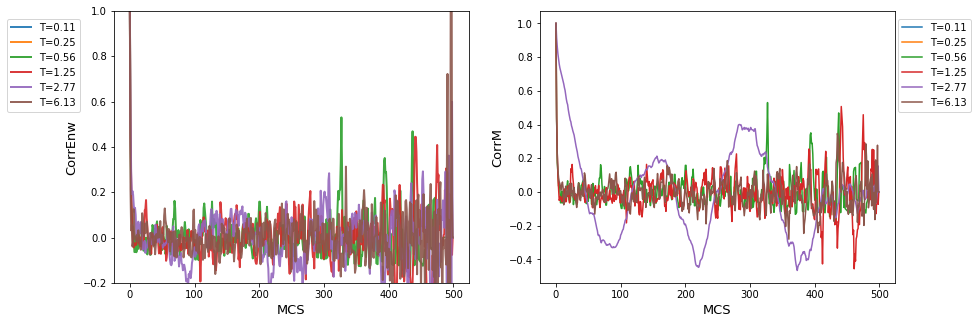

In [65]:
%matplotlib inline
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
t = np.arange(len(LcorrEnw_data[0][0]))
i = 1 # index of scales
l = 1; k = 34
step = 6

for j, item in enumerate(temperatures[l:k:step]):
    ax1.plot(t,LcorrEnw_data[i][j*step+l], linewidth=2, label=('T={}'.format(np.around(item,2))), alpha=0.9)
    ax2.plot(t, LcorrMdata[i][j*step+l], label=('T={}'.format(np.around(item,2))))

    
ax1.set_xlabel('MCS',fontsize=13); ax1.set_ylabel('CorrEnw', fontsize=13)
ax2.set_xlabel('MCS',fontsize=13); ax2.set_ylabel('CorrM', fontsize=13)
ax1.legend(loc=(-0.3,0.63)); ax2.legend(loc=(1.01,0.63))
ax1.set_ylim([-0.2,1])

print('L = %d'%(possibleScales[i]))
#print('Correlation time (decay length) of the energy(nng):', LtauEnw[i])
#print('Correlation time (decay length) of the magnetization:', LtauM[i])


In [66]:
%matplotlib inline
wg.interact(plot_corr_shells, Lcorr_neg_data=wg.fixed(Lcorr_neg_data), Lcorr_nwe_data=wg.fixed(Lcorr_nwe_data), 
            Lidx=(0,len(possibleScales)-1), Tidx=(0,len(temperatures)-1), step=(1,4))

interactive(children=(IntSlider(value=1, description='Lidx', max=2), IntSlider(value=16, description='Tidx', m…

<function __main__.plot_corr_shells(Lcorr_neg_data, Lcorr_nwe_data, Lidx, Tidx, step)>

### Average energy

In [67]:
#temperatures = np.geomspace(0.1, 8, 35)
print(len(temperatures))
print(temperatures)

new = False
if new:
    scales = []
    Len_nw_data = []; Len_nw_err = []
    Lmag_data = []; Lmag_err = []
    Lneg_data = []; Lneg_err = []
    Lnwe_data = []; Lnwe_err = []
    L_CvEnw_data = []; Lsusc_data = []
    L_Cv_neg_data = []; L_Cv_nwe_data = []
    
    # Save energy data as dictionary:
    nwpLdata = {'Len_nw_data': Len_nw_data, 'Len_nw_err': Len_nw_err, 'L_CvEnw_data': L_CvEnw_data, 'Lneg_data': Lneg_data,
                'Lneg_err': Lneg_err, 'Lnwe_data': Lnwe_data, 'Lnwe_err': Lnwe_err, 'L_Cv_neg_data': L_Cv_neg_data, 
                'L_Cv_nwe_data': L_Cv_nwe_data, 'temperatures': temperatures, 'scales': scales, 't_prod': t_prod}
    pickle.dump(nwpLdata, open('nwp1Dfinite_size_scaling_data.p', 'wb'))
    
    # Save magnetization data as dictionary:
    nwpLdata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales}
    pickle.dump(nwpLdata_mag, open('nwp1Dfinite_size_scaling_data_mag.p', 'wb'))
    

34
[0.1        0.11420087 0.13041838 0.14893891 0.17008953 0.19424371
 0.221828   0.25332949 0.28930447 0.33038821 0.37730619 0.43088694
 0.49207661 0.56195575 0.64175832 0.73289356 0.83697078 0.95582787
 1.0915637  1.24657519 1.42359964 1.62576311 1.85663553 2.12029384
 2.42139391 2.76525279 3.1579426  3.60639777 4.11853745 4.70340539
 5.37132964 6.13410492 7.00520088 8.        ]


In [68]:
# Set system parameters (note that these are global!):
#scales = [64, 256, 1024] # Lattice number
#temperatures = np.linspace(0.01, 8, 60) # Temperature (critical at around 0)
#temperatures = np.sort(np.random.normal(0.01,0.6,50))# Temperature (critical at around 0)

run = False

if run:
    N = 256; idx = 1
    t_eq = 1000
    t_prod = 10000
    t_sim = t_eq + t_prod
    
    nRGsteps, neg_baseline = number_of_RGsteps(N)
    
    en_nw_data = np.zeros(len(temperatures)); en_nw_err = np.zeros(len(temperatures))#; tausE = []
    mag_data = np.zeros(len(temperatures)); mag_err = np.zeros(len(temperatures))
    neg_data = np.zeros((len(temperatures),nRGsteps)); neg_err = np.zeros((len(temperatures),nRGsteps))
    nwe_data = np.zeros((len(temperatures),nRGsteps)); nwe_err = np.zeros((len(temperatures),nRGsteps))
    
    CvEnw_data = np.zeros(len(temperatures)); Cv_neg_data = np.zeros((len(temperatures),nRGsteps))
    Cv_nwe_data = np.zeros((len(temperatures),nRGsteps))
    susc_data = np.zeros(len(temperatures))

    # Initial lattice configuration
    lattice = -1*np.ones(N)  
    #lattice = np.random.choice([1,-1],size=N)
    
    results = Parallel(n_jobs=2, verbose=20)(delayed(simulate_eff)(lattice, T) for lattice,T in zip(LinitC[idx], temperatures))
    
    results1 = results[:]
    for i,T in enumerate(temperatures):
        Enw = results1[i][1]; M = results1[i][2]; neg = results1[i][3]; nwe = results1[i][4]
        en_nw_data[i] = np.mean(Enw[t_eq:]); en_nw_err[i] = np.std(Enw[t_eq:])
        mag_data[i] = np.mean(abs(M[t_eq:])); mag_err[i] = np.std(abs(M[t_eq:]))
        neg_data[i] = np.mean(neg[t_eq:], axis=0); neg_err[i] = np.std(neg[t_eq:], axis=0)
        nwe_data[i] = np.mean(nwe[t_eq:], axis=0); nwe_err[i] = np.std(nwe[t_eq:], axis=0)
    
        CvEnw_data[i] = specific_heat(Enw[t_eq:]); susc_data[i] = susceptiblity(abs(M[t_eq:]))
        Cv_neg_data[i] = specific_heat(neg[t_eq:]); Cv_nwe_data[i] = specific_heat(nwe[t_eq:])

    '''for j,T in enumerate(temperatures):
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability 
        # (only need first two values for metropolis)
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, neg, nwe = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = C[-1]
        
        en_data[j] = np.mean(E[t_eq:]); en_err[j] = np.std(E[t_eq:])#; tausE[j] = tauE
        mag_data[j] = np.mean(abs(M[t_eq:])); mag_err[j] = np.std(abs(M[t_eq:]))
        neg_data[j] = np.mean(neg[t_eq:], axis=0); neg_err[j] = np.std(neg[t_eq:], axis=0)
        nwe_data[j] = np.mean(nwe[t_eq:], axis=0); nwe_err[j] = np.std(nwe[t_eq:], axis=0)
        
        CvEdata[j] = specific_heat(E[t_eq:]); Cv_neg_data[j] = specific_heat(neg[t_eq:])
        Cv_nwe_data[j] = specific_heat(nwe[t_eq:])
        susc_data[j] = susceptiblity(abs(M[t_eq:]))
        
    Len_data.append(en_data); Len_err.append(en_err)#; LtausE.append(tausE)
    Lmag_data.append(mag_data); Lmag_err.append(mag_err)
    Lneg_data.append(neg_data); Lneg_err.append(neg_err)#; Ltaus_nng.append(taus_nng)
    Lnwe_data.append(nwe_data); Lnwe_err.append(nwe_err)
    L_CvEdata.append(CvEdata); L_Cv_neg_data.append(Cv_neg_data); L_Cv_nwe_data.append(Cv_nwe_data)
    Lsusc_data.append(susc_data)


LnegBDdata = []; LnegBDerr = []; L_Cv_negBDdata = []
for i,L in enumerate(scales):
    LnegBDdata.append(Lneg_data[i][:,0]); LnegBDerr.append(Lneg_err[i][:,0])
    L_Cv_negBDdata.append(L_Cv_neg_data[i][:,0])'''

In [70]:
nwpLdata = pickle.load(open('nwp1Dfinite_size_scaling_data.p', 'rb'))
Len_nw_data = nwpLdata['Len_nw_data']; Len_nw_err = nwpLdata['Len_nw_err']; L_CvEnw_data = nwpLdata['L_CvEnw_data']
Lneg_data = nwpLdata['Lneg_data']; Lneg_err = nwpLdata['Lneg_err']; Lnwe_data = nwpLdata['Lnwe_data']
Lnwe_err = nwpLdata['Lnwe_err']; L_Cv_neg_data = nwpLdata['L_Cv_neg_data']; L_Cv_nwe_data = nwpLdata['L_Cv_nwe_data']
temperatures = nwpLdata['temperatures']; scales = nwpLdata['scales']

nwpLdata_mag = pickle.load(open('nwp1Dfinite_size_scaling_data_mag.p', 'rb'))
Lmag_data= nwpLdata_mag['Lmag_data']; Lmag_err = nwpLdata_mag['Lmag_err']; Lsusc_data = nwpLdata_mag['Lsusc_data']

save = False
if save:
    scales.append(N)
    Len_nw_data.append(en_nw_data); Len_nw_err.append(en_nw_err)
    Lmag_data.append(mag_data); Lmag_err.append(mag_err)
    Lneg_data.append(neg_data); Lneg_err.append(neg_err)
    Lnwe_data.append(nwe_data); Lnwe_err.append(nwe_err)
    L_CvEnw_data.append(CvEnw_data); Lsusc_data.append(susc_data)
    L_Cv_neg_data.append(Cv_neg_data); L_Cv_nwe_data.append(Cv_nwe_data)
    
    # Save energy data as dictionary:
    nwpLdata = {'Len_nw_data': Len_nw_data, 'Len_nw_err': Len_nw_err, 'L_CvEnw_data': L_CvEnw_data, 'Lneg_data': Lneg_data,
                'Lneg_err': Lneg_err, 'Lnwe_data': Lnwe_data, 'Lnwe_err': Lnwe_err, 'L_Cv_neg_data': L_Cv_neg_data, 
                'L_Cv_nwe_data': L_Cv_nwe_data, 'temperatures': temperatures, 'scales': scales, 't_prod': t_prod}
    pickle.dump(nwpLdata, open('nwp1Dfinite_size_scaling_data.p', 'wb'))
    
    # Save magnetization data as dictionary:
    nwpLdata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales}
    pickle.dump(nwpLdata_mag, open('nwp1Dfinite_size_scaling_data_mag.p', 'wb'))

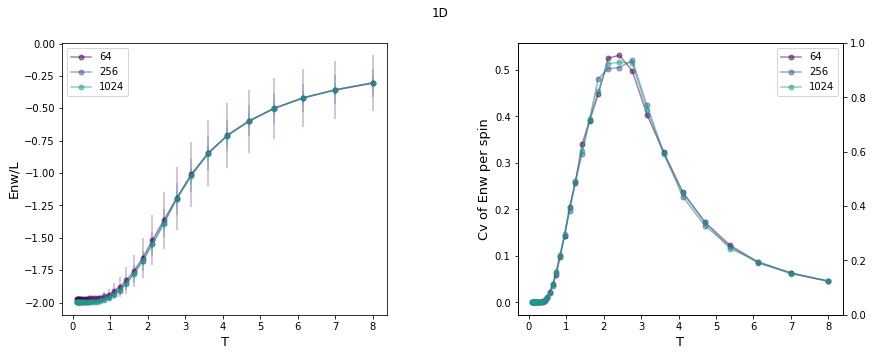

In [71]:
# Energy ~ Number of Edges
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5)); fig4.suptitle('1D')
fig4.subplots_adjust(wspace=0.4)
# energy:
ax41 = fig4.add_subplot(1,2,1)
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('Enw/L', fontsize=13)#, color='y')
# specific heat:
ax43 = fig4.add_subplot(1,2,2); ax44 =ax43.twinx()
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('Cv of Enw per spin', fontsize=13)

for i,L in enumerate(scales):
    # energy:
    ax41.plot(temperatures, Len_nw_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    ax41.errorbar(temperatures, Len_nw_data[i]/L, yerr=Len_nw_err[i]/L, alpha=0.3, linestyle='', color=cm.viridis(i*70))
    # specific heat:
    ax43.plot(temperatures, L_CvEnw_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    
ax41.legend()
ax43.legend()

if save:
    # Save energy data as dictionary:
    nwpLdata = {'Len_nw_data': Len_nw_data, 'Len_nw_err': Len_nw_err, 'L_CvEnw_data': L_CvEnw_data, 'Lneg_data': Lneg_data,
                'Lneg_err': Lneg_err, 'Lnwe_data': Lnwe_data, 'Lnwe_err': Lnwe_err, 'L_Cv_neg_data': L_Cv_neg_data, 
                'L_Cv_nwe_data': L_Cv_nwe_data, 'temperatures': temperatures, 'scales': scales, 't_prod': t_prod}
    pickle.dump(nwpLdata, open('nwp1Dfinite_size_scaling_data.p', 'wb'))

256


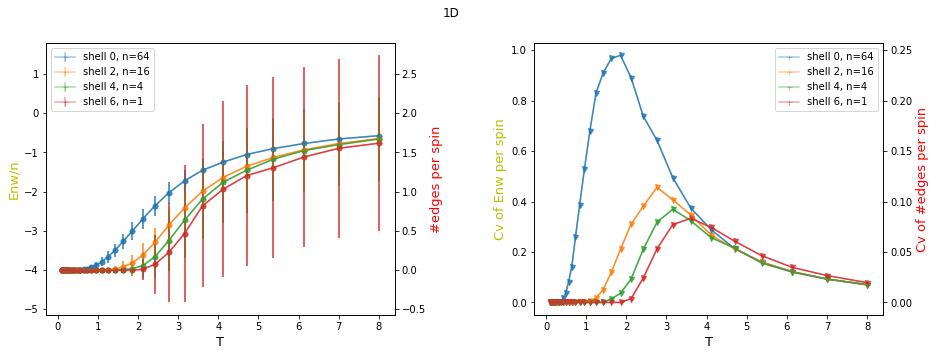

In [72]:
# edges in inner shells
%matplotlib inline

Lidx  = 1 # scale index
L = scales[Lidx]
nRGsteps = len(Lneg_data[Lidx][0,:])
step = 2
print(L)

fig1 = plt.figure(figsize=(15,5)); fig1.suptitle('1D')
ax11 = fig1.add_subplot(1,2,1); ax12 = ax11.twinx()
ax13 = fig1.add_subplot(1,2,2); ax14 = ax13.twinx()
fig1.subplots_adjust(wspace=0.4)

for i in range(nRGsteps)[::step]:
    l = np.arange(nRGsteps)
    n_l = N/(2**l)
    ax11.errorbar(temperatures, Lnwe_data[Lidx][:,i]/n_l[i], marker='o', yerr=Lnwe_err[Lidx][:,i]/n_l[i], 
                  label='shell %d, n=%d'%(i,n_l[i]), markersize=5, alpha=0.8)
    ax11.set_xlabel('T',fontsize=13)
    ax11.set_ylabel('Enw/n', fontsize=13, color='y')
    
    ax12.errorbar(temperatures, Lneg_data[Lidx][:,i]/n_l[i], yerr=Lneg_err[Lidx][:,i]/n_l[i], label='shell %d, n=%d'%(i,n_l[i]), 
                  marker='+', markersize=5, alpha=0.4)
    ax12.set_ylabel('#edges per spin', fontsize=13, color='r')
    
    ax13.plot(temperatures, L_Cv_nwe_data[Lidx][:,i]/n_l[i], marker='v', markersize=5, alpha=0.8)
    ax13.set_xlabel('T',fontsize=13)
    ax13.set_ylabel('Cv of Enw per spin', fontsize=13, color='y')

    ax14.plot(temperatures, L_Cv_neg_data[Lidx][:,i]/n_l[i], label='shell %d, n=%d'%(i,n_l[i]), marker='+', markersize=5, 
              alpha=0.4)
    ax14.set_ylabel('Cv of #edges per spin', fontsize=13, color='r')

    
ax12.legend(loc='upper left')
ax14.legend()

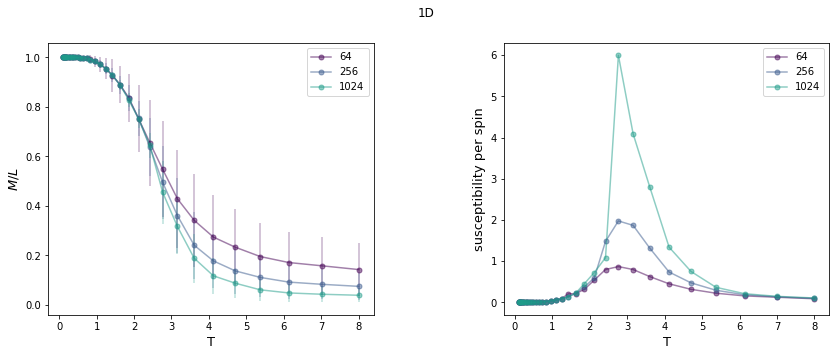

In [73]:
# magnetization ~ susceptibility
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5)); fig4.suptitle('1D')
fig4.subplots_adjust(wspace=0.4)
# magnetization:
ax41 = fig4.add_subplot(1,2,1)
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('$M/L$', fontsize=13)#, color='y')

# susceptibility:
ax43 = fig4.add_subplot(1,2,2)
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('susceptibility per spin', fontsize=13)

for i,L in enumerate(scales):
    # magnetization:
    ax41.plot(temperatures, Lmag_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    ax41.errorbar(temperatures, Lmag_data[i]/L, yerr=Lmag_err[i]/L, alpha=0.3, linestyle='', color=cm.viridis(i*70))
    #ax42.errorbar(temperatures, Lnng_data[i], yerr=Lnng_err[i], linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # susceptibility:
    ax43.plot(temperatures, Lsusc_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
ax41.legend()
ax43.legend()

if save:
    # Save data as dictionary:
    nwpLdata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales, 't_prod': t_prod}
    pickle.dump(nwpLdata_mag, open('nwp1Dfinite_size_scaling_data_mag.p', 'wb'))

# Free energy

In [74]:
def exc_free_energy_calc():
    f = np.zeros(len(temperatures))
    for i,T in enumerate(temperatures):
        f[i] = -T*np.log(2*np.cosh(1/T))
    return f

In [75]:
def create_energy_hist(x, mode):
    lowB = np.min(x)
    upperB = np.max(x)
    n = round(abs(upperB-lowB)*100)+2
    if mode == 'nw':
        n = round(abs(upperB-lowB)*100)+2
    print(n)
    bin_edges = np.linspace(lowB,upperB,n)
    #bin_edges = np.histogram_bin_edges(en, bins='doane')
    #h, b = stats.histogram(x, bins='blocks')
    h, b = np.histogram(x, bins=bin_edges)#, density=True)
    idx = np.where(h>0)
    h = h[idx]
    b = b[idx]
    return h, b
    

In [76]:
def free_energy_calc(nE, en, g, temp):
    nE = Decimal(nE); g = Decimal(g); en = Decimal(en);  temp = Decimal(temp)
    ln = Decimal(g).ln() - Decimal(nE).ln() # equivalent to ln(g/nE)
    f = -temp*ln + en
    return f

In [77]:
def g_transfer(nE1, en1, g1, nE2, en2, temp):
    nE1 = Decimal(nE1); en1 = Decimal(en1); g1 = Decimal(g1); nE2 = Decimal(nE2); en2 = Decimal(en2); temp = Decimal(temp)
    boltz_exp = np.exp(-(1/temp)*(en1-en2))
    #print('bExp', boltz_exp)
    g2 = round(g1*(nE2/nE1)*boltz_exp)
    return g2

In [78]:
def find_intersection(x_targ, y_targ, x2, y2):
    m = len(x_targ)
    n = len(x2)
    min_dist = 1000
    coords = np.zeros((2,2))
    for i in range(m):
        for j in range(n):
            d = (x2[j]-x_targ[i])**2 + (y2[j]-y_targ[i])**2
            if d < min_dist:
                min_dist = d
                coords[0][0] = x_targ[i]
                coords[0][1] = y_targ[i]
                coords[1][0] = x2[j]
                coords[1][1] = y2[j]
    return(coords)

In [79]:
def free_energyVStemp(hists, bins, g0):
    f = np.zeros(len(temperatures))
    idx = np.argmax(hists[0])
    nE = hists[0][idx]
    en = bins[0][idx]
    g = g0
    
    for i,temperature in enumerate(temperatures):
        #print('g',g)
        f[i] = free_energy_calc(nE, en, g, temperature)   
        
        if i == (len(temperatures)-1):
            break
        #print(i)
        hist1 = hists[i]
        bins1 = bins[i]
        hist2 = hists[i+1]
        bins2 = bins[i+1]
        l = np.argmax(hist1)
        k = np.argmax(hist2)+1
        #print('l:', l, 'k:', k)
        if bins2[k-1] < bins1[l]:
            raise ValueError('Data of consecutive histograms %d and %d are not consecutive'%(i,i+1))
          
        # get intersection
        coords = find_intersection(bins1[l:], hist1[l:], bins2[:k], hist2[:k])
        
        en1 = coords[0][0]
        nE1 = coords[0][1]
               
        g = g_transfer(nE, en, g, nE1, en1, temperature)
        #print(coords)
        en = coords[1][0]
        nE = coords[1][1]  
    return f
            

In [80]:
def check_visual(i, hists, bins):

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)
    
    b1 = bins[i]
    h1 = hists[i]
    #print(h1)
    l = np.argmax(h1)
    temperature1 = temperatures[i]
    
    b2 = bins[i+1]
    h2 = hists[i+1]
    k = np.argmax(h2)+1
    temperature2 = temperatures[i+1]
    
    ax.plot(b1/N, h1,label='T=%.2f'%(temperature1), markersize=3, linestyle='-', marker='o', linewidth=1, color='#1f77b4')
    ax.plot(b1[l:]/N, h1[l:], markersize=6, color='#1f77b4', marker='o', linewidth=2)
    
    ax.plot(b2/N, h2,label='T=%.2f'%(temperature2), markersize=3, linestyle='-', marker='o', linewidth=1, color='orange')
    ax.plot(b2[:k]/N, h2[:k], markersize=6, color='orange', marker='o', linewidth=2)
    
    ax.legend()
    #ax5.set_yscale('log')

### Equilibrium for Free Energy

In [81]:
lowRange = np.arange(0.1, 1.1, 0.095)
highRange = np.geomspace(1.1, 6, 14)
temperatures = np.sort(np.concatenate((lowRange,highRange)))
print(len(temperatures))
print(temperatures)

new = False
if new:
    possibleScales = []
    LinitC = []; Len_nw_data = []
    Lmag_data= []; t_sim = 0
    
    nwpEqDataF = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Lmag_data': Lmag_data, 
                 'Len_nw_data': Len_nw_data, 'LinitC': LinitC}
    
    pickle.dump(nwpEqDataF, open('nwp1DeqDataFreeEnergy.p', 'wb'))

25
[0.1        0.195      0.29       0.385      0.48       0.575
 0.67       0.765      0.86       0.955      1.05       1.1
 1.25333284 1.42803929 1.62709868 1.85390565 2.11232804 2.40677283
 2.74226131 3.12451469 3.56005172 4.05629977 4.62172157 5.2659595
 6.        ]


In [82]:
run = False
# Set system parameters (note that these are global!):
N = 1024 # Lattice number
#temperatures = np.geomspace(0.1, 4, 6) # Temperature (critical at around 0.2)
t_eq = 1000
t_prod = 0
t_sim = t_eq + t_prod

geom = 1/2

mag_data = []
en_nw_data = []
initC = []

lattice = np.ones(N)

if run:
    for T in temperatures:
        #lattice = np.random.choice([1,-1],size=(N,N)) # Initial lattice configuration
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, Enw, M, _, _ = simulate_eff(lattice, T, geom)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
        initC.append(np.copy(C[-1]))
    
        mag_data.append(abs(M))
        en_nw_data.append(Enw)

In [85]:
nwpEqDataF = pickle.load(open('nwp1DeqDataFreeEnergy.p', 'rb'))
possibleScales = nwpEqDataF['possibleScales']; temperatures = nwpEqDataF['temperatures']
Len_nw_data = nwpEqDataF['Len_nw_data']; Lmag_data = nwpEqDataF['Lmag_data']
LinitC = nwpEqDataF['LinitC']


save = False
if save:
    possibleScales.append(N)
    Len_nw_data.append(en_nw_data); Lmag_data.append(mag_data)
    LinitC.append(initC); 
    
    nwpEqDataF = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Len_nw_data': Len_nw_data, 
                   'Lmag_data': Lmag_data, 'LinitC': LinitC}
    pickle.dump(nwpEqDataF, open('nwp1DeqDataFreeEnergy.p', 'wb'))

In [86]:
idx = 2
print(Lmag_data[idx][13][-1])
print(np.sum(LinitC[idx][13]))

504.0
504.0


In [87]:
idx = 2
L = possibleScales[idx]
print(LinitC[idx][0])
print(np.where(LinitC[idx][0]!=np.ones(L)))

[1. 1. 1. ... 1. 1. 1.]
(array([], dtype=int64),)


possibleScales:  [64, 256, 1024]


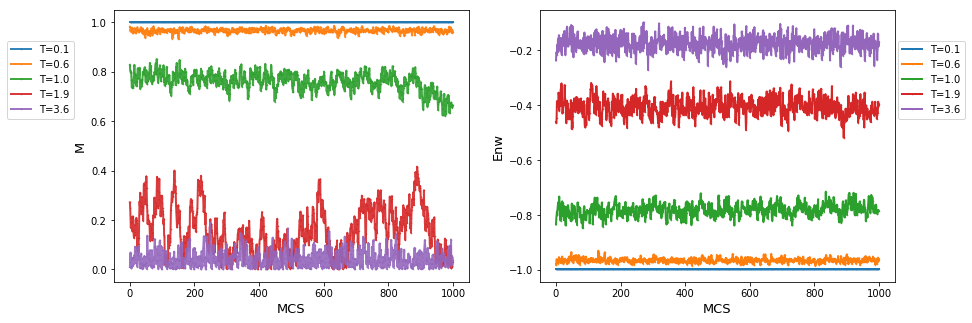

In [88]:
%matplotlib inline
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
save = False
idx = 2

if not save:
    nwpEqDataF = pickle.load(open('nwp1DeqDataFreeEnergy.p', 'rb'))
    t_sim = nwpEqDataF['t_sim']; possibleScales = nwpEqDataF['possibleScales']; Lmag_data = nwpEqDataF['Lmag_data']
    Len_nw_data = nwpEqDataF['Len_nw_data']; temperatures = nwpEqDataF['temperatures']

print('possibleScales: ', possibleScales)    

N = possibleScales[idx]    
t = np.arange(t_sim)
step = 5

for i, item in enumerate(temperatures[::step]):
    ax1.plot(t,Lmag_data[idx][i*step]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1, alpha=0.9)
    ax2.plot(t,Len_nw_data[idx][i*step]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1)
    
ax1.set_xlabel('MCS',fontsize=13); ax1.set_ylabel('M', fontsize=13)
ax2.set_xlabel('MCS',fontsize=13); ax2.set_ylabel('Enw', fontsize=13)
ax1.legend(loc=(-0.3,0.6)); ax2.legend(loc=(1.01,0.6))


if save:
    plt.savefig('nwp1DequitimeF')
    nwpEqDataF = {'t_sim': t_sim, 'possibleScales': possibleScales, 'temperatures': temperatures, 'Len_nw_data': Len_nw_data, 
                   'Lmag_data': Lmag_data, 'LinitC': LinitC}
    pickle.dump(nwpEqDataF, open('nwp1DeqDataFreeEnergy.p', 'wb'))

### Free Energy Simulation

In [89]:
#lowRange = np.geomspace(0.1, 3, 22, endpoint=False)
#highRange = np.linspace(3.2, 6, 3)
#temperatures = np.sort(np.concatenate((lowRange,highRange)))
print(len(temperatures))
print(temperatures)

f_exact = exc_free_energy_calc()


new = False
if new:
    scales = []
    Len_nw_data = []; Len_nw_err = []
    Len_nw_hist_data = []; Len_nw_bin_edges_data = []
    Len_nw_fr = []; Len_nwS = []
    

    # Save data as dictionary:
    nwpLf_data = {'f_exact': f_exact, 'Len_nw_fr': Len_nw_fr, 'Len_nwS': Len_nwS, 'Len_nw_data': Len_nw_data, 
                  'Len_nw_err': Len_nw_err, 'Len_nw_hist_data': Len_nw_hist_data, 
                  'Len_nw_bin_edges_data': Len_nw_bin_edges_data, 'temperatures': temperatures, 'scales': scales, 
                  't_prod': t_prod}
    pickle.dump(nwpLf_data, open('nwp1Dfree_energy_finite_size_scaling.p', 'wb'))
    

25
[0.1        0.195      0.29       0.385      0.48       0.575
 0.67       0.765      0.86       0.955      1.05       1.1
 1.25333284 1.42803929 1.62709868 1.85390565 2.11232804 2.40677283
 2.74226131 3.12451469 3.56005172 4.05629977 4.62172157 5.2659595
 6.        ]


In [87]:
# Set system parameters (note that these are global!):
#scales = [64, 256, 1024] # Lattice number
#low_range = np.linspace(0.1, 3, 20); high_range = np.linspace(3.5, 6, 5)
#temperatures = np.concatenate((low_range, high_range))
#temperatures = np.linspace(0.1, 5, 25) # Temperature (critical at around 2.27)
#temperatures = np.arange(0.1, 6, 0.19)

run = False

if run:
    N = 1024; idx = 2
    t_eq = 1000
    t_prod = 20000
    t_sim = t_eq + t_prod
    
    geom = 1/2
    
    en_nw_data = np.zeros(len(temperatures)); en_nw_err = np.zeros(len(temperatures))
    en_nw_hist_data = []; en_nw_bin_edges_data = []

    # Initial lattice configuration
    lattice = -1*np.ones(N)  
    # lattice = np.random.choice([1,-1],size=(N,N))
    
    results = Parallel(n_jobs=-3, verbose=30)(delayed(simulate_eff)(lattice, T, geom) for lattice,T in zip(LinitC[idx], temperatures))
    results1 = results[:]
    
    for i,T in enumerate(temperatures):
        Enw = results1[i][1]
        en_nw_data[i] = np.mean(Enw[t_eq:]); en_nw_err[i] = np.std(Enw[t_eq:])
        
        en_nw_hist, en_nw_bin_edges = create_energy_hist(Enw[t_eq:], 'nw')
        en_nw_hist_data.append(en_nw_hist/t_prod); en_nw_bin_edges_data.append(en_nw_bin_edges)
  
    '''for j,T in enumerate(temperatures):
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance 
        #probability (only need first two values for metropolis)
        #A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, neg, nwe = simulate_eff(lattice)
        nweBD = nwe[:,0]
        clear_output(wait=True)
    
        lattice = C[-1]
        
        en_hist, en_bin_edges = create_energy_hist(E[t_eq:], 'en')
        nweBDhist, nweBDbin_edges = create_energy_hist(nweBD[t_eq:], 'nw')
        
        en_data[j] = np.mean(E[t_eq:])#; en_err[j] = np.std(E[t_eq::snap])
        nweBDdata[j] = np.mean(nweBD[t_eq:])#; neg_err[j] = np.std(neg[t_eq:])
        
        en_hist_data.append(en_hist/t_prod); en_bin_edges_data.append(en_bin_edges)
        nweBDhist_data.append(nweBDhist/t_prod); nweBDbin_edges_data.append(nweBDbin_edges)
    '''

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed: 169.6min
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed: 173.9min
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed: 182.5min
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed: 184.4min
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed: 184.5min
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed: 185.2min
[Parallel(n_jobs=-3)]: Done   7 out of  25 | elapsed: 190.7min remaining: 490.4min
[Parallel(n_jobs=-3)]: Done   8 out of  25 | elapsed: 191.3min remaining: 406.5min
[Parallel(n_jobs=-3)]: Done   9 out of  25 | elapsed: 198.3min remaining: 352.6min
[Parallel(n_jobs=-3)]: Done  10 out of  25 | elapsed: 208.2min remaining: 312.3min
[Parallel(n_jobs=-3)]: Done  11 out of  25 | elapsed: 360.7min remaining: 459.1min
[Parallel(n_jobs=-3)]: Done  12 out of  25 | elapsed: 361.1min remaining: 391.2min
[Parallel(n_jobs=-3)]: Done  13 out of  25 | el

2.0
402.0
1002.0
2202.0
4602.0
7202.0
9202.0
11802.0
16202.0
16602.0
19402.0
19602.0
23402.0
25002.0
25202.0
25802.0
27002.0
23002.0
24002.0
21402.0
23802.0
20602.0
20402.0
19402.0
20602.0


[Parallel(n_jobs=-3)]: Done  25 out of  25 | elapsed: 486.4min remaining:    0.0s
[Parallel(n_jobs=-3)]: Done  25 out of  25 | elapsed: 486.4min finished
/software/local/lib64/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


### Visually check histograms

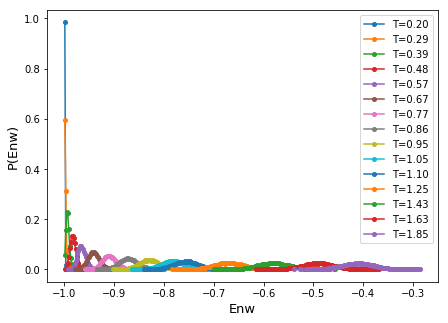

In [88]:
%matplotlib inline
fig5 = plt.figure(figsize=(7,5))
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xlabel('Enw', fontsize=13)
ax5.set_ylabel('P(Enw)', fontsize=13)

l = 1
k = 15
for i,temperature in enumerate(temperatures[l:k+1]):
    ax5.plot(en_nw_bin_edges_data[l+i]/N, en_nw_hist_data[l+i],label='T=%.2f'%(temperature), markersize=4, linestyle='-', 
             marker='o')
    
ax5.legend()
#ax5.set_yscale('log')

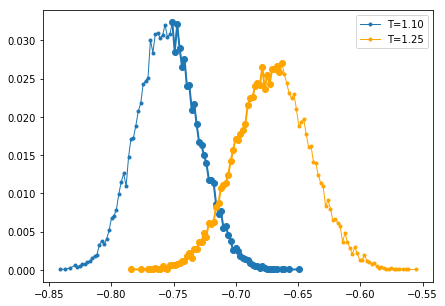

<function __main__.check_visual(i, hists, bins)>

In [89]:
%matplotlib inline
wg.interact(check_visual, hists=wg.fixed(en_nw_hist_data), bins=wg.fixed(en_nw_bin_edges_data), i=(0,len(temperatures)-2))

### Plot free energy

In [90]:
#f_exact = exc_free_energy_calc()
en_nw_fr = free_energyVStemp(en_nw_hist_data, en_nw_bin_edges_data, 1)
print(en_nw_fr)

[-1023.         -1023.00316505 -1023.150932   -1024.09165338
 -1026.87946159 -1032.52300119 -1041.74952588 -1054.9300788
 -1072.59067615 -1094.84806695 -1121.73402933 -1137.65113363
 -1194.10449503 -1271.36603033 -1372.25832704 -1498.86801058
 -1653.70865816 -1839.02159513 -2057.62743604 -2312.32334629
 -2607.5292557  -2947.90575044 -3339.39601245 -3787.57265056
 -4300.55636659]


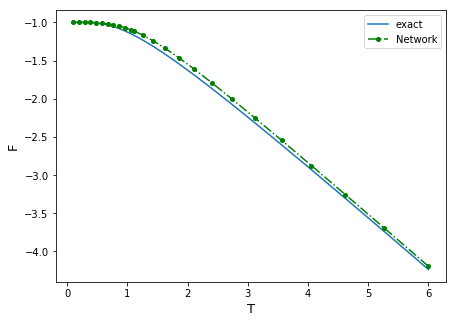

In [91]:
%matplotlib inline
fig7 = plt.figure(figsize=(7,5))
ax7 = fig7.add_subplot(1,1,1)#; ax8 = ax7.twinx()
ax7.set_xlabel('T', fontsize=13)
ax7.set_ylabel('F', fontsize=13)
#ax8.set_ylabel('Network F', fontsize=13, color='g')

ax7.plot(temperatures, f_exact, label='exact')
ax7.plot(temperatures, en_nw_fr/(N), label='Network', marker='o', markersize=4, linestyle='-.', color='g')

ax7.legend()

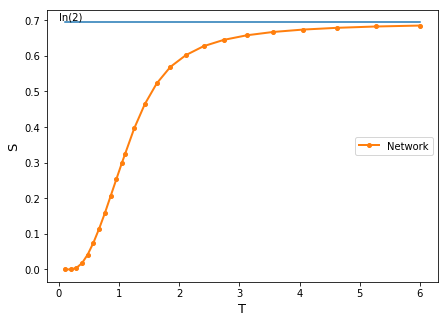

In [92]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)#; ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('S', fontsize=13)
#ax1.set_ylabel('nweBD S', fontsize=13, color='g')

en_nwS = (en_nw_data-en_nw_fr)/(temperatures)
ax.annotate('ln(2)', (0,0.7))
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)))
ax.plot(temperatures, en_nwS/N, label='Network', linewidth=2, marker='o', markersize=4)

ax.legend(loc='center right')

In [91]:
nwpLf_data = pickle.load(open('nwp1Dfree_energy_finite_size_scaling.p', 'rb'))
f_exact = nwpLf_data['f_exact']; Len_nw_fr = nwpLf_data['Len_nw_fr']; Len_nwS = nwpLf_data['Len_nwS'] 
Len_nw_data = nwpLf_data['Len_nw_data'] ; Len_nw_err = nwpLf_data['Len_nw_err'] 
Len_nw_hist_data = nwpLf_data['Len_nw_hist_data']; Len_nw_bin_edges_data = nwpLf_data['Len_nw_bin_edges_data']
temperatures = nwpLf_data['temperatures']; scales = nwpLf_data['scales']

save = False
if save:
    scales.append(N)
    Len_nw_fr.append(en_nw_fr); Len_nwS.append(en_nwS)
    Len_nw_data.append(en_nw_data); Len_nw_err.append(en_nw_err)
    Len_nw_hist_data.append(en_nw_hist_data); Len_nw_bin_edges_data.append(en_nw_bin_edges_data)
    
    # Save energy data as dictionary:
    nwpLf_data = {'f_exact': f_exact, 'Len_nw_fr': Len_nw_fr, 'Len_nwS': Len_nwS, 'Len_nw_data': Len_nw_data, 
                  'Len_nw_err': Len_nw_err, 'Len_nw_hist_data': Len_nw_hist_data, 
                  'Len_nw_bin_edges_data': Len_nw_bin_edges_data, 'temperatures': temperatures, 'scales': scales, 
                  't_prod': t_prod}
    pickle.dump(nwpLf_data, open('nwp1Dfree_energy_finite_size_scaling.p', 'wb'))

In [92]:
print(scales)
print(len(temperatures))

[64, 256, 1024]
25


### Plot free energy for various system size  

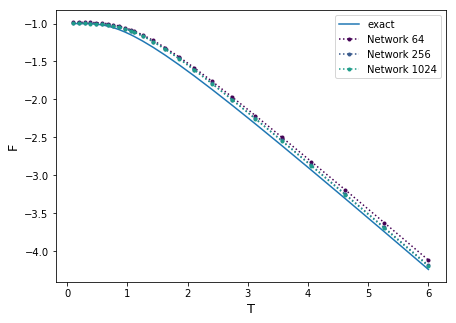

In [93]:
%matplotlib inline

fig8 = plt.figure(figsize=(7,5))
ax8 = fig8.add_subplot(1,1,1)#; ax9 = ax8.twinx()
ax8.set_xlabel('T', fontsize=13)
ax8.set_ylabel('F', fontsize=13)
#ax9.set_ylabel('neg F', fontsize=13)

geom = 1

ax8.plot(temperatures, f_exact, label='exact')

for i,L in enumerate(scales):
    ax8.plot(temperatures, Len_nw_fr[i]/(geom*L), label='Network %d'%(L), linestyle=':', color=cm.viridis(i*70), marker='o', 
             markersize=3)
    
ax8.legend()
#ax9.legend(loc='lower left')

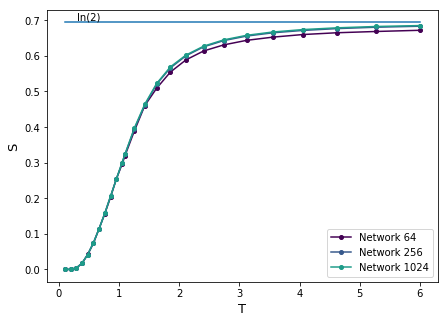

In [94]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)#; ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('S', fontsize=13)
#ax1.set_ylabel('neg S', fontsize=13)
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)))
ax.annotate('ln(2)', (0.3,0.7))

for i,L in enumerate(scales):
    ax.plot(temperatures, Len_nwS[i]/L, color=cm.viridis(i*70), marker='o', markersize=4, label='Network %d'%(L))

ax.legend()